In [205]:
import pickle
import pandas as pd
import os
import git
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
## tokenize the text..
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tweet_tknzr = TweetTokenizer()
## keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.models import Model, Input 
from keras.models import Sequential
from keras.layers import Dense, concatenate
from keras.layers import Flatten
from keras.layers import SpatialDropout1D
from keras.layers import Embedding 
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Model, Input
from keras import regularizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

In [2]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [7]:
top_dir = os.path.join(get_git_root(os.getcwd()))
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
poly_dir = os.path.join(model_dir,"poly_users")
embeddings_dir = os.path.join(input_dir,"embeddings")
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [8]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [9]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [10]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [ ]:
## @ returns the data in that year
def get_year_data(year):
    print("year",year)
    users_ = list(first_data["userID"].loc[ 
        ((first_data.juul_first.dt.year <= year)  & (first_data.juul_first.dt.year > (year-1)))
        & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
                ]) # users who will change after september

    poly_turn = list(first_data["userID"].loc[
        (first_data.juul_first.dt.year <= year)  & 
        ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


    print("users that will change",len(poly_turn))
    print("total users",len(users_))

    ## getting the input data
    data_ = juul_data.loc[juul_data.userID.isin(users_)]
    print("length of data",len(data_))

    ## get label - they reamain same for this task as the no of users, we only change the tweets data
    users_ = data_.userID.unique()
    users_lbl = pd.DataFrame(users_,columns=["userID"])
    users_lbl["label"] = 0  ## initialize
    users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
    len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
    return ((year,data_,users_lbl))

In [119]:
## HELPER FUCNTIONS
# setup env
import nltk
from numpy import zeros
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)] ## remove punctuations
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def get_max_length(df):
    ## max_length
    lengths = df["tweetText"].progress_apply(get_length)
    max_len = int(lengths.quantile(0.95))
    return (max_len)

def get_length(s):
    a = list(s.split())
    return(len(a))

def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT )', "",text)         ## remove the retweet info as they dont convey any information
    text = re.sub(r'(^:)',"",text)
    text = text.rstrip() 
    text = text.lstrip()
    return(text)

## returns the emnbedding matrix for the lstm model
def get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr):
    word2vec = get_word2vec(embedding_file)
    from numpy import zeros
    embedding_matrix = zeros((vocab_size, dimension))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [278]:
## models file
from sklearn.model_selection import cross_val_score

def get_baseline_scores(X_train,X_test,Y_train,Y_test):
    
    print("training the models")
    print("svm")
    svm = LinearSVC(C=1,verbose=1)
    svm.fit(X_train,Y_train)
    svm_pred = svm.predict(X_test)
    svm_score = precision_recall_fscore_support(Y_test,svm_pred,average=None)[2]  # return the f-score
    svm_f1 =  cross_val_score(svm, X_test, Y_test, cv=5,scoring='f1_macro').mean()
    print('svm cross val score mean',svm_f1,'\n')
    
    print("random_forest")
    rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
    rf.fit(X_train,Y_train)
    rf_pred = rf.predict(X_test)
    rf_score = precision_recall_fscore_support(Y_test,rf_pred,average=None)[2]
    rf_f1  = cross_val_score(rf, X_test, Y_test, cv=5,scoring='f1_macro').mean()
    print('rf cross val score mean',rf_f1,'\n')
    
    print("xgBoost")
    xgb = XGBClassifier()
    xgb.fit(X_train, Y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_score = precision_recall_fscore_support(Y_test,xgb_pred,average=None)[2]
    xgb_f1 =  cross_val_score(xgb, X_test, Y_test, cv=5,scoring='f1_macro').mean()
    print('xgb corss val score mean',xgb_f1,'\n')
    
    y_pred = [1 for x in range(len(Y_test))]
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    maj_score = precision_recall_fscore_support(Y_test,y_pred,average=None)[2]
    
    models = {0:[svm_pred,svm,"svm"], 1:[rf_pred,rf,"rf"] ,2:[xgb_pred,xgb,"xgb"]}
    model_idx = np.argmax([svm_f1,rf_f1,xgb_f1])  ## get the best performing model
    
    print("selecting the best model",models[model_idx][2])

    print("job finished")
    all_scores = {
        'svm': [svm,svm_score],
        'rf' : [rf,rf_score],
        'xg_boost': [xgb,xgb_score],
        'maj': [maj_score],
    }
    return (all_scores,models[model_idx])

def prepare_data(input_data,users_labelled):
    ## preapring the user data
    user_data = input_data.groupby(by="userID").agg({  'tweetText' : 'count',
                                                       'followersCount': 'first',
                                                       'friendsCount' : 'first',
                                                       'statusesCount' : 'first',
                                                       'favourites_count' : 'first',
                                                       'listedCount' : 'first',
                                                      })
    user_data = user_data.rename(columns={'tweetText': 'tweetCount'})
    
    # preapring text
    tweet_data = input_data.groupby(by="userID")["tweetText"].apply(lambda x: "%s" % ' '.join(x)).reset_index()
    ## cleaning the text
    tweet_data["tweetText"] = tweet_data["tweetText"].progress_apply(clean_text)
    tweet_data["tweetText"] = tweet_data["tweetText"].progress_apply(get_tokens).str.join(" ")
    
    ## merging the text and user data
    final_data = user_data.join(tweet_data.set_index("userID"),on="userID",how="inner").reset_index()
    final_data = final_data.fillna(0)   
    
    ## extract the labels
    y = list(final_data.join(users_labelled.set_index("userID"),on="userID",how="inner")["label"]) 
    print("downsampling")
    
    ## downsampling based on userIDS
    userIDs = np.array(list(final_data.userID)).reshape(-1,1)
    rus = RandomUnderSampler(random_state=0)
    rus.fit(userIDs,y)
    userIDs , y_sam = rus.fit_sample(userIDs,y)
    input_data = (final_data.loc[final_data.userID.isin(userIDs.flatten())])
    print("downsampled data length",len(input_data))
    
    print("train-test split")
    train_data,test_data,Y_train,Y_test  = train_test_split(input_data, y_sam,test_size =0.20,random_state= 4,shuffle=True ,
                                                          stratify= y_sam)
    return(train_data,test_data,Y_train,Y_test)

## return user fatures
def prepare_user_features(input_):
    user_data = input_[["followersCount","friendsCount","statusesCount"
                          ,"favourites_count","listedCount","tweetCount",]]
    ## followerss/ friends ration
    user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]

    ## using log of each of the columns
    user_data[["followersCount","friendsCount"
          ,"statusesCount","favourites_count",
          "listedCount"]] = np.log(user_data[["followersCount","friendsCount","statusesCount","favourites_count",
                                        "listedCount"]])
    
    user_data["unigrams"] = list(input_["tweetText"].apply(get_length))

    ## replace the na and inf values 
    user_data = user_data.replace([np.inf, -np.inf], np.nan)
    user_data.replace(np.nan,0)
    user_data = user_data.fillna(0)

    ## normalizing the values
    user_data = (user_data - user_data.min())/(user_data.max()-user_data.min())
    user_data = user_data.replace([np.inf, -np.inf], np.nan)
    user_data = user_data.fillna(0)

    X = user_data.values
    return (X,user_data)

def run_user_features(train_data,test_data,Y_train,Y_test):
    X_train,_ = prepare_user_features(train_data)
    X_test,_ = prepare_user_features(test_data)
    
    scores,best_model = get_baseline_scores(X_train,X_test,Y_train,Y_test)
    return(scores,best_model[0],best_model[1])

##models

## @ return a trained svm model
def svm_wrapper(X_train,Y_train):
    svm = LinearSVC(C=1, verbose=1)
    svm.fit(X_train, Y_train)
    return svm

def training_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def run_lstm(train_data,test_data,Y_train,Y_test,dimension,epoch,metrics,weight=None):
    scores = []
    ## print winodow , max_len for analysis purpose
    max_len = get_max_length(train_data)
    if max_len > 60:
        max_len = 60
    print("max_length",max_len)

    ## prepare the tokenizer
    print("preparing the tokenizer")
    keras_tkzr = keras_Tokenizer()
    keras_tkzr.fit_on_texts(train_data["tweetText"])
    vocab_size = len(keras_tkzr.word_index) + 1
    print("vocalb",vocab_size)

    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr) ## tokenizer contains the vocalb info

    ## encoding the docs
    print("encoding the data")
    encoded_docs = keras_tkzr.texts_to_sequences(train_data["tweetText"])
    X_train = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))

    ## encoding the test data
    encoded_docs = keras_tkzr.texts_to_sequences(test_data["tweetText"])
    X_test = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))

    print("X-train",X_train.shape)
    print("X-test",X_test.shape)

    ## getting the user features
    X_train_user,_ = prepare_user_features(train_data)
    X_test_user,_ = prepare_user_features(test_data)
    
    user_feat_len  = (X_train_user.shape[1])
    print("creating lstm model")
    model = create_model(max_len,user_feat_len,vocab_size,dimension,embedding_matrix)

    print("training the model with balance dataset")
    history = model.fit([X_train,X_train_user],Y_train,validation_split=0.25 , nb_epoch = epoch, 
                        verbose = 1,batch_size=32,class_weight= None,)

    ##plotting trainin validation - no point as we dont want ot look at accuarcy
    training_plot(history)


    scores = get_cross_val_score(train_data,Y_train,dimension,n_splits=5,nb_epoch=epoch)

    print("generating classfication report")
    loss, accuracy = model.evaluate([X_test,X_test_user], Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    ## lstm model
    temp = model.predict([X_test,X_test_user])
    y_pred = [np.argmax(value) for value in temp]  ## sigmoid
    print('  Classification Report test:\n',classification_report(Y_test,y_pred),'\n')

    print("lstm cross val score class mono",scores[0])
    print("lstm cross val score class poly",scores[1])

    print("job finished")
    return (scores,y_pred,model,keras_tkzr,max_len)

## @ return a trained svm model on text features for LR
def run_text_features(train_data,test_data,Y_train,Y_test):
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(train_data["tweetText"])  ## fit on train data
    
     ## transform train and test data
    X_test = tf_idf.transform(test_data["tweetText"])
    X_train = tf_idf.transform(train_data["tweetText"])
    
    
    ## reduce the dimesionality
    svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
    svd.fit(X_train)  
    X_train = svd.transform(X_train)
    X_test = svd.transform(X_test)
    
    scores,best_model = get_baseline_scores(X_train,X_test,Y_train,Y_test)
    return (scores,best_model[0],best_model[1],tf_idf,svd)

def cal_text_pred(test_data,Y_test,model,tf_idf,svd):
    X_test = tf_idf.transform(test_data["tweetText"])
    X_test = svd.transform(X_test) ## reduce the dimensionality
    y_pred = model.predict(X_test)
    return y_pred

def cal_lstm_pred(test_data,Y_test,model,keras_tkzr,max_len):
     ## encoding the test data
    encoded_docs = keras_tkzr.texts_to_sequences(test_data["tweetText"])
    X_test = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    X_test_user,_ = prepare_user_features(test_data)
    ## calculate the model predictions
    temp = model.predict([X_test,X_test_user])
    y_pred = [np.argmax(value) for value in temp]  ## sigmoid
    
    return y_pred

def cal_user_pred(test_data,Y_test,model):
    X_test,_ = prepare_user_features(test_data)
    y_pred = model.predict(X_test)
    return y_pred

# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
#         split = file.read().splitlines()
        for line in file:
            split_line = line.split(' ')
            key = split_line[0] # the first word is the key
            value = np.array([float(val) for val in split_line[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")
        
from keras.callbacks import Callback
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_predict = np.array([np.argmax(value) for value in val_predict])
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        print('  Classification Report:\n',classification_report(val_targ,val_predict),'\n')
        return

In [272]:
## handle two different inputs and then concatenate them (user and text features)
## input = [words_in,user_in]
def create_model(max_len,user_feature_len,vocalb_size,dimension,embedding_matrix):
    ## handle text features..
    words_in = Input(shape=(max_len,))
    emb_word = Embedding(vocalb_size,dimension,weights=[embedding_matrix],input_length=max_len)(words_in) 
    lstm_word =  Bidirectional (LSTM (100,return_sequences=False,dropout=0.50,kernel_regularizer=regularizers.l2(0.01)),merge_mode='concat')(emb_word)
    lstm_word = Dense(user_feature_len,activation='relu')(lstm_word)
    
    ## takes the user features as input
    user_input = Input(shape=(user_feature_len,))
    
    ## concatenate both of the features
    modelR = concatenate([lstm_word, user_input])
    # modelR = SpatialDropout1D(0.1)(modelR)
    output = Dense(2,activation='softmax')(modelR)
    model = Model([words_in,user_input],output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model
    

In [282]:
## return cross_val mean score for each class
def get_cross_val_score(train_data,Y_train,dimension,n_splits,nb_epoch):
    scores = []
    train_ids = list(train_data.index)
    kFold = StratifiedKFold(n_splits=n_splits)
    for train, test in kFold.split(train_ids,Y_train):
        
        max_len = get_max_length(train_data.loc[train])
        if max_len > 60:
            max_len = 60
        print("max_length",max_len)

        ## prepare the tokenizer
        print("preparing the tokenizer")
        keras_tkzr = keras_Tokenizer()
        keras_tkzr.fit_on_texts(train_data.loc[train]["tweetText"])
        vocab_size = len(keras_tkzr.word_index) + 1
        print("vocalb",vocab_size)

        ## embedding matrix
        print("creating glove embeddign matrix")
        embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr) ## tokenizer contains the vocalb info

        X_train_user,_ = prepare_user_features(train_data.loc[train])
        X_test_user,_ = prepare_user_features(train_data.loc[test])

        encoded_docs = keras_tkzr.texts_to_sequences(train_data.loc[train]["tweetText"])
        X_train = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
        encoded_docs = keras_tkzr.texts_to_sequences(train_data.loc[test]["tweetText"])
        X_test = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
        
        user_feat_len  = (X_train_user.shape[1])
        print("creating lstm model")
        model = create_model(max_len,user_feat_len,vocab_size,dimension,embedding_matrix)

        history = model.fit([X_train,X_train_user],Y_train[train],validation_split=0.25 , nb_epoch = epoch,
                            batch_size=32,class_weight= None,)
        ## prediction
        temp = model.predict([X_test,X_test_user])
        y_pred = [np.argmax(value) for value in temp]  ## sigmoid
        f1 = precision_recall_fscore_support(Y_train[test],y_pred,average=None)[2]
        scores.append(f1)
    score1 = np.mean([ele[0] for ele in scores])
    score2 = np.mean([ele[1] for ele in scores])
    return (score1,score2)

In [259]:
## gathering data in different range of intervals
bucket_data = []
bucket_data.append(get_year_data(2015))
bucket_data.append(get_year_data(2016))
bucket_data.append(get_year_data(2017))

year 2015
users that will change 97
total users 1049
length of data 2944
year 2016
users that will change 313
total users 1636
length of data 6475
year 2017
users that will change 9525
total users 40236
length of data 111735






  0%|          | 0/1049 [00:00<?, ?it/s]



100%|██████████| 1049/1049 [00:00<00:00, 46687.45it/s]



  0%|          | 0/1049 [00:00<?, ?it/s]

************
preparing the data






 25%|██▍       | 258/1049 [00:00<00:00, 2570.85it/s]



 53%|█████▎    | 557/1049 [00:00<00:00, 2653.06it/s]



 75%|███████▍  | 782/1049 [00:00<00:00, 2517.74it/s]



 97%|█████████▋| 1019/1049 [00:00<00:00, 2471.42it/s]



100%|██████████| 1049/1049 [00:00<00:00, 2471.65it/s]



  0%|          | 0/155 [00:00<?, ?it/s]



100%|██████████| 155/155 [00:00<00:00, 62849.68it/s]

downsampling
downsampled data length 194
train-test split
runnning classfier to get user features
max_length 60
preparing the tokenizer
vocalb 2073
creating glove embeddign matrix
encoding the data
X-train (155, 60)
X-test (39, 60)


/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in log


creating lstm model
training the model with balance dataset


/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/ipykernel_launcher.py:191: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 116 samples, validate on 39 samples
Epoch 1/20
116/116 [==============================] - 14s 122ms/step - loss: 3.8111 - acc: 0.5000 - val_loss: 3.5938 - val_acc: 0.4615
Epoch 2/20
116/116 [==============================] - 1s 10ms/step - loss: 3.4845 - acc: 0.5431 - val_loss: 3.3045 - val_acc: 0.4359
Epoch 3/20
116/116 [==============================] - 1s 10ms/step - loss: 3.1921 - acc: 0.5345 - val_loss: 3.0431 - val_acc: 0.5128
Epoch 4/20
116/116 [==============================] - 1s 10ms/step - loss: 2.9152 - acc: 0.5948 - val_loss: 2.8040 - val_acc: 0.4103
Epoch 5/20
116/116 [==============================] - 1s 10ms/step - loss: 2.6629 - acc: 0.6034 - val_loss: 2.5841 - val_acc: 0.4615
Epoch 6/20
116/116 [==============================] - 1s 10ms/step - loss: 2.4498 - acc: 0.5948 - val_loss: 2.3724 - val_acc: 0.4615
Epoch 7/20
116/116 [==============================] - 1s 10ms/step - loss: 2.2419 - acc: 0.5862 - val_loss: 2.1755 - val_acc: 0.4615
Epoch 8/20
116/116 [==

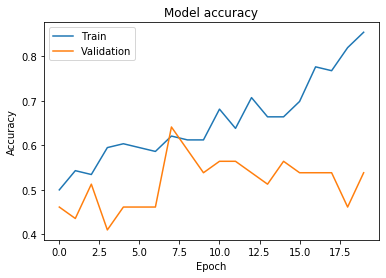

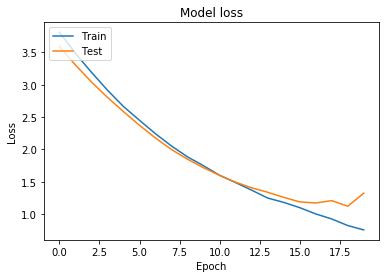





  0%|          | 0/123 [00:00<?, ?it/s]



100%|██████████| 123/123 [00:00<00:00, 63487.50it/s]

max_length 60
preparing the tokenizer
vocalb 1731
creating glove embeddign matrix
creating lstm model


/home/drew_william2345/anaconda3/envs/multimodal-env/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 92 samples, validate on 31 samples
Epoch 1/20
92/92 [==============================] - 16s 172ms/step - loss: 3.8276 - acc: 0.3696 - val_loss: 3.6509 - val_acc: 0.4839
Epoch 2/20
92/92 [==============================] - 1s 10ms/step - loss: 3.5689 - acc: 0.5978 - val_loss: 3.4256 - val_acc: 0.4516
Epoch 3/20
92/92 [==============================] - 1s 10ms/step - loss: 3.3449 - acc: 0.5652 - val_loss: 3.2157 - val_acc: 0.4516
Epoch 4/20
92/92 [==============================] - 1s 10ms/step - loss: 3.1412 - acc: 0.5543 - val_loss: 3.0179 - val_acc: 0.4839
Epoch 5/20
92/92 [==============================] - 1s 10ms/step - loss: 2.9295 - acc: 0.6957 - val_loss: 2.8349 - val_acc: 0.4516
Epoch 6/20
92/92 [==============================] - 1s 10ms/step - loss: 2.7416 - acc: 0.6087 - val_loss: 2.6652 - val_acc: 0.5161
Epoch 7/20
92/92 [==============================] - 1s 10ms/step - loss: 2.5724 - acc: 0.6739 - val_loss: 2.5091 - val_acc: 0.6129
Epoch 8/20
92/92 [===================





  0%|          | 0/123 [00:00<?, ?it/s]



100%|██████████| 123/123 [00:00<00:00, 44790.71it/s]

max_length 60
preparing the tokenizer
vocalb 1454
creating glove embeddign matrix
creating lstm model
Train on 92 samples, validate on 31 samples
Epoch 1/20
92/92 [==============================] - 14s 147ms/step - loss: 3.8528 - acc: 0.5435 - val_loss: 3.7222 - val_acc: 0.4839
Epoch 2/20
92/92 [==============================] - 1s 9ms/step - loss: 3.5993 - acc: 0.5435 - val_loss: 3.4599 - val_acc: 0.4839
Epoch 3/20
92/92 [==============================] - 1s 9ms/step - loss: 3.3541 - acc: 0.5435 - val_loss: 3.2325 - val_acc: 0.5484
Epoch 4/20
92/92 [==============================] - 1s 9ms/step - loss: 3.1469 - acc: 0.5000 - val_loss: 3.0271 - val_acc: 0.4516
Epoch 5/20
92/92 [==============================] - 1s 9ms/step - loss: 2.9325 - acc: 0.5870 - val_loss: 2.8376 - val_acc: 0.4516
Epoch 6/20
92/92 [==============================] - 1s 9ms/step - loss: 2.7559 - acc: 0.5543 - val_loss: 2.6610 - val_acc: 0.4516
Epoch 7/20
92/92 [==============================] - 1s 10ms/step - loss





  0%|          | 0/124 [00:00<?, ?it/s]



100%|██████████| 124/124 [00:00<00:00, 41939.66it/s]

max_length 60
preparing the tokenizer
vocalb 1878
creating glove embeddign matrix
creating lstm model
Train on 93 samples, validate on 31 samples
Epoch 1/20
93/93 [==============================] - 14s 152ms/step - loss: 3.8756 - acc: 0.4624 - val_loss: 3.6721 - val_acc: 0.5806
Epoch 2/20
93/93 [==============================] - 1s 9ms/step - loss: 3.6159 - acc: 0.4839 - val_loss: 3.4401 - val_acc: 0.4839
Epoch 3/20
93/93 [==============================] - 1s 9ms/step - loss: 3.3689 - acc: 0.5269 - val_loss: 3.2327 - val_acc: 0.4839
Epoch 4/20
93/93 [==============================] - 1s 9ms/step - loss: 3.1778 - acc: 0.4301 - val_loss: 3.0439 - val_acc: 0.6452
Epoch 5/20
93/93 [==============================] - 1s 9ms/step - loss: 2.9727 - acc: 0.5161 - val_loss: 2.8614 - val_acc: 0.6452
Epoch 6/20
93/93 [==============================] - 1s 9ms/step - loss: 2.7563 - acc: 0.5806 - val_loss: 2.6882 - val_acc: 0.6452
Epoch 7/20
93/93 [==============================] - 1s 9ms/step - loss:





  0%|          | 0/125 [00:00<?, ?it/s]



100%|██████████| 125/125 [00:00<00:00, 45197.24it/s]

max_length 60
preparing the tokenizer
vocalb 1805
creating glove embeddign matrix
creating lstm model
Train on 93 samples, validate on 32 samples
Epoch 1/20
93/93 [==============================] - 15s 156ms/step - loss: 4.0308 - acc: 0.4839 - val_loss: 3.7760 - val_acc: 0.5312
Epoch 2/20
93/93 [==============================] - 1s 9ms/step - loss: 3.7506 - acc: 0.4624 - val_loss: 3.4933 - val_acc: 0.5312
Epoch 3/20
93/93 [==============================] - 1s 9ms/step - loss: 3.4993 - acc: 0.3978 - val_loss: 3.2471 - val_acc: 0.5312
Epoch 4/20
93/93 [==============================] - 1s 10ms/step - loss: 3.2527 - acc: 0.4624 - val_loss: 3.0439 - val_acc: 0.5312
Epoch 5/20
93/93 [==============================] - 1s 10ms/step - loss: 3.0271 - acc: 0.5269 - val_loss: 2.8626 - val_acc: 0.5625
Epoch 6/20
93/93 [==============================] - 1s 10ms/step - loss: 2.8760 - acc: 0.4516 - val_loss: 2.6949 - val_acc: 0.4688
Epoch 7/20
93/93 [==============================] - 1s 10ms/step - l





  0%|          | 0/125 [00:00<?, ?it/s]



100%|██████████| 125/125 [00:00<00:00, 42970.90it/s]

max_length 60
preparing the tokenizer
vocalb 1885
creating glove embeddign matrix
creating lstm model
Train on 93 samples, validate on 32 samples
Epoch 1/20
93/93 [==============================] - 15s 159ms/step - loss: 3.8352 - acc: 0.5484 - val_loss: 3.6877 - val_acc: 0.5000
Epoch 2/20
93/93 [==============================] - 1s 10ms/step - loss: 3.5945 - acc: 0.6022 - val_loss: 3.4537 - val_acc: 0.5000
Epoch 3/20
93/93 [==============================] - 1s 10ms/step - loss: 3.3593 - acc: 0.5914 - val_loss: 3.2337 - val_acc: 0.5000
Epoch 4/20
93/93 [==============================] - 1s 10ms/step - loss: 3.1453 - acc: 0.6129 - val_loss: 3.0268 - val_acc: 0.5312
Epoch 5/20
93/93 [==============================] - 1s 10ms/step - loss: 2.9334 - acc: 0.6022 - val_loss: 2.8301 - val_acc: 0.5000
Epoch 6/20
93/93 [==============================] - 1s 10ms/step - loss: 2.7522 - acc: 0.6022 - val_loss: 2.6462 - val_acc: 0.5000
Epoch 7/20
93/93 [==============================] - 1s 10ms/step -





  0%|          | 0/1636 [00:00<?, ?it/s]



100%|██████████| 1636/1636 [00:00<00:00, 42432.47it/s]



  0%|          | 0/1636 [00:00<?, ?it/s]



 16%|█▌        | 258/1636 [00:00<00:00, 2564.55it/s]



 24%|██▎       | 387/1636 [00:00<00:00, 1976.79it/s]



 39%|███▉      | 643/1636 [00:00<00:00, 2119.34it/s]



 52%|█████▏    | 848/1636 [00:00<00:00, 2097.47it/s]



 64%|██████▍   | 1049/1636 [00:00<00:00, 2067.50it/s]



 79%|███████▉  | 1296/1636 [00:00<00:00, 2173.29it/s]



 91%|█████████ | 1491/1636 [00:00<00:00, 1607.20it/s]



100%|██████████| 1636/1636 [00:00<00:00, 1880.25it/s]



  0%|          | 0/414 [00:00<?, ?it/s]



100%|██████████| 414/414 [00:00<00:00, 77505.89it/s]

downsampling
downsampled data length 518
train-test split
runnning classfier to get user features
max_length 60
preparing the tokenizer
vocalb 3137
creating glove embeddign matrix
encoding the data
X-train (414, 60)
X-test (104, 60)
creating lstm model
training the model with balance dataset
Train on 310 samples, validate on 104 samples
Epoch 1/20
310/310 [==============================] - 17s 55ms/step - loss: 3.5649 - acc: 0.4903 - val_loss: 3.1766 - val_acc: 0.4423
Epoch 2/20
310/310 [==============================] - 3s 10ms/step - loss: 2.8948 - acc: 0.4419 - val_loss: 2.5954 - val_acc: 0.4135
Epoch 3/20
310/310 [==============================] - 3s 10ms/step - loss: 2.3527 - acc: 0.5290 - val_loss: 2.1245 - val_acc: 0.4135
Epoch 4/20
310/310 [==============================] - 3s 10ms/step - loss: 1.9347 - acc: 0.5290 - val_loss: 1.7452 - val_acc: 0.4615
Epoch 5/20
310/310 [==============================] - 3s 9ms/step - loss: 1.6068 - acc: 0.5484 - val_loss: 1.4815 - val_acc: 0.4

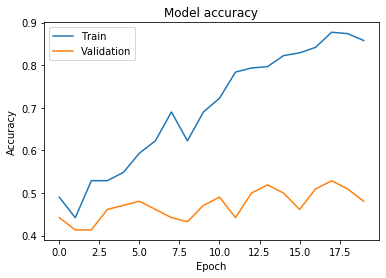

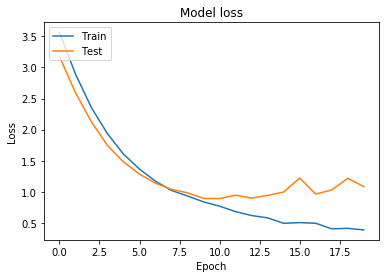





  0%|          | 0/330 [00:00<?, ?it/s]



100%|██████████| 330/330 [00:00<00:00, 78589.62it/s]

max_length 60
preparing the tokenizer
vocalb 2839
creating glove embeddign matrix
creating lstm model
Train on 247 samples, validate on 83 samples
Epoch 1/20
247/247 [==============================] - 17s 68ms/step - loss: 3.6272 - acc: 0.5466 - val_loss: 3.2736 - val_acc: 0.4578
Epoch 2/20
247/247 [==============================] - 2s 10ms/step - loss: 3.0491 - acc: 0.5020 - val_loss: 2.7467 - val_acc: 0.4819
Epoch 3/20
247/247 [==============================] - 2s 10ms/step - loss: 2.5579 - acc: 0.5304 - val_loss: 2.3114 - val_acc: 0.5181
Epoch 4/20
247/247 [==============================] - 2s 10ms/step - loss: 2.1481 - acc: 0.5870 - val_loss: 1.9556 - val_acc: 0.5060
Epoch 5/20
247/247 [==============================] - 2s 10ms/step - loss: 1.8250 - acc: 0.5101 - val_loss: 1.6707 - val_acc: 0.4940
Epoch 6/20
247/247 [==============================] - 2s 10ms/step - loss: 1.5650 - acc: 0.5668 - val_loss: 1.4443 - val_acc: 0.4940
Epoch 7/20
247/247 [==============================] - 





  0%|          | 0/330 [00:00<?, ?it/s]



100%|██████████| 330/330 [00:00<00:00, 81582.01it/s]

max_length 60
preparing the tokenizer
vocalb 2586
creating glove embeddign matrix
creating lstm model
Train on 247 samples, validate on 83 samples
Epoch 1/20
247/247 [==============================] - 17s 69ms/step - loss: 3.6780 - acc: 0.4980 - val_loss: 3.3123 - val_acc: 0.4699
Epoch 2/20
247/247 [==============================] - 2s 10ms/step - loss: 3.0963 - acc: 0.4777 - val_loss: 2.8003 - val_acc: 0.4699
Epoch 3/20
247/247 [==============================] - 2s 10ms/step - loss: 2.6018 - acc: 0.5587 - val_loss: 2.3859 - val_acc: 0.4458
Epoch 4/20
247/247 [==============================] - 2s 10ms/step - loss: 2.2244 - acc: 0.5182 - val_loss: 2.0399 - val_acc: 0.4699
Epoch 5/20
247/247 [==============================] - 2s 10ms/step - loss: 1.8806 - acc: 0.5830 - val_loss: 1.7749 - val_acc: 0.4217
Epoch 6/20
247/247 [==============================] - 2s 10ms/step - loss: 1.6212 - acc: 0.6032 - val_loss: 1.5528 - val_acc: 0.4458
Epoch 7/20
247/247 [==============================] - 





  0%|          | 0/332 [00:00<?, ?it/s]



100%|██████████| 332/332 [00:00<00:00, 73931.98it/s]

max_length 60
preparing the tokenizer
vocalb 2770
creating glove embeddign matrix
creating lstm model
Train on 249 samples, validate on 83 samples
Epoch 1/20
249/249 [==============================] - 17s 69ms/step - loss: 3.6621 - acc: 0.4980 - val_loss: 3.3070 - val_acc: 0.5060
Epoch 2/20
249/249 [==============================] - 2s 10ms/step - loss: 3.0891 - acc: 0.4659 - val_loss: 2.7998 - val_acc: 0.4337
Epoch 3/20
249/249 [==============================] - 2s 10ms/step - loss: 2.5944 - acc: 0.5462 - val_loss: 2.3762 - val_acc: 0.4578
Epoch 4/20
249/249 [==============================] - 2s 10ms/step - loss: 2.2091 - acc: 0.5382 - val_loss: 2.0382 - val_acc: 0.4819
Epoch 5/20
249/249 [==============================] - 2s 10ms/step - loss: 1.8914 - acc: 0.5542 - val_loss: 1.7593 - val_acc: 0.4699
Epoch 6/20
249/249 [==============================] - 2s 10ms/step - loss: 1.6282 - acc: 0.5944 - val_loss: 1.5302 - val_acc: 0.5181
Epoch 7/20
249/249 [==============================] - 





  0%|          | 0/332 [00:00<?, ?it/s]



100%|██████████| 332/332 [00:00<00:00, 57088.76it/s]

max_length 60
preparing the tokenizer
vocalb 2815
creating glove embeddign matrix
creating lstm model
Train on 249 samples, validate on 83 samples
Epoch 1/20
249/249 [==============================] - 17s 70ms/step - loss: 3.6781 - acc: 0.4779 - val_loss: 3.3312 - val_acc: 0.5060
Epoch 2/20
249/249 [==============================] - 2s 10ms/step - loss: 3.0799 - acc: 0.4940 - val_loss: 2.8080 - val_acc: 0.4337
Epoch 3/20
249/249 [==============================] - 2s 10ms/step - loss: 2.5870 - acc: 0.5301 - val_loss: 2.3736 - val_acc: 0.4819
Epoch 4/20
249/249 [==============================] - 2s 10ms/step - loss: 2.1980 - acc: 0.5141 - val_loss: 2.0206 - val_acc: 0.5181
Epoch 5/20
249/249 [==============================] - 2s 10ms/step - loss: 1.8690 - acc: 0.5663 - val_loss: 1.7380 - val_acc: 0.4699
Epoch 6/20
249/249 [==============================] - 2s 10ms/step - loss: 1.6018 - acc: 0.6145 - val_loss: 1.5182 - val_acc: 0.4940
Epoch 7/20
249/249 [==============================] - 





  0%|          | 0/332 [00:00<?, ?it/s]



100%|██████████| 332/332 [00:00<00:00, 106493.49it/s]

max_length 60
preparing the tokenizer
vocalb 2767
creating glove embeddign matrix
creating lstm model
Train on 249 samples, validate on 83 samples
Epoch 1/20
249/249 [==============================] - 18s 71ms/step - loss: 3.6771 - acc: 0.5141 - val_loss: 3.3714 - val_acc: 0.4096
Epoch 2/20
249/249 [==============================] - 2s 10ms/step - loss: 3.0999 - acc: 0.5060 - val_loss: 2.8449 - val_acc: 0.3494
Epoch 3/20
249/249 [==============================] - 2s 10ms/step - loss: 2.6162 - acc: 0.5341 - val_loss: 2.4426 - val_acc: 0.3735
Epoch 4/20
249/249 [==============================] - 2s 10ms/step - loss: 2.2284 - acc: 0.5141 - val_loss: 2.1025 - val_acc: 0.3735
Epoch 5/20
249/249 [==============================] - 2s 10ms/step - loss: 1.8854 - acc: 0.5783 - val_loss: 1.8131 - val_acc: 0.3976
Epoch 6/20
249/249 [==============================] - 2s 9ms/step - loss: 1.6383 - acc: 0.5783 - val_loss: 1.5819 - val_acc: 0.3735
Epoch 7/20
249/249 [==============================] - 2





  0%|          | 0/40236 [00:00<?, ?it/s]



 15%|█▌        | 6128/40236 [00:00<00:00, 61279.18it/s]



 32%|███▏      | 12683/40236 [00:00<00:00, 62495.65it/s]



 48%|████▊     | 19154/40236 [00:00<00:00, 63143.54it/s]



 64%|██████▍   | 25847/40236 [00:00<00:00, 64233.25it/s]



 81%|████████  | 32446/40236 [00:00<00:00, 64749.03it/s]



 96%|█████████▋| 38809/40236 [00:00<00:00, 64395.43it/s]



100%|██████████| 40236/40236 [00:00<00:00, 63490.82it/s]



  0%|          | 0/40236 [00:00<?, ?it/s]



  1%|          | 214/40236 [00:00<00:18, 2134.68it/s]



  1%|          | 386/40236 [00:00<00:20, 1990.30it/s]



  1%|▏         | 561/40236 [00:00<00:20, 1910.40it/s]



  2%|▏         | 769/40236 [00:00<00:20, 1947.26it/s]



  2%|▏         | 994/40236 [00:00<00:19, 2024.05it/s]



  3%|▎         | 1180/40236 [00:00<00:19, 1964.13it/s]



  3%|▎         | 1365/40236 [00:00<00:20, 1926.70it/s]



  4%|▍         | 1559/40236 [00:00<00:20, 1930.32it/s]



  4%|▍         | 1775/40236 

downsampling
downsampled data length 18612
train-test split
runnning classfier to get user features
max_length 60
preparing the tokenizer
vocalb 13826
creating glove embeddign matrix
encoding the data
X-train (14889, 60)
X-test (3723, 60)
creating lstm model
training the model with balance dataset
Train on 11166 samples, validate on 3723 samples
Epoch 1/20
11166/11166 [==============================] - 126s 11ms/step - loss: 1.0356 - acc: 0.4655 - val_loss: 0.7040 - val_acc: 0.4402
Epoch 2/20
11166/11166 [==============================] - 111s 10ms/step - loss: 0.6981 - acc: 0.4996 - val_loss: 0.6918 - val_acc: 0.5235
Epoch 3/20
11166/11166 [==============================] - 110s 10ms/step - loss: 0.6916 - acc: 0.5338 - val_loss: 0.6877 - val_acc: 0.5520
Epoch 4/20
11166/11166 [==============================] - 110s 10ms/step - loss: 0.6882 - acc: 0.5615 - val_loss: 0.6839 - val_acc: 0.5708
Epoch 5/20
11166/11166 [==============================] - 111s 10ms/step - loss: 0.6854 - acc: 0

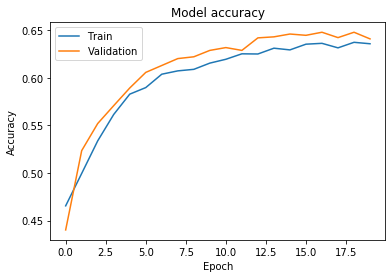

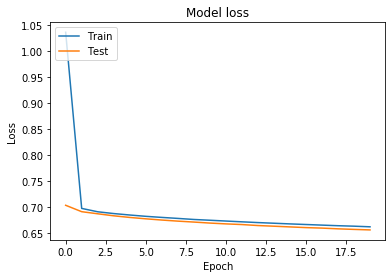





  0%|          | 0/11911 [00:00<?, ?it/s]



100%|██████████| 11911/11911 [00:00<00:00, 213049.29it/s]

max_length 60
preparing the tokenizer
vocalb 12497
creating glove embeddign matrix
creating lstm model
Train on 8933 samples, validate on 2978 samples
Epoch 1/20
8933/8933 [==============================] - 101s 11ms/step - loss: 1.0927 - acc: 0.5350 - val_loss: 0.6932 - val_acc: 0.5567
Epoch 2/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6894 - acc: 0.5565 - val_loss: 0.6888 - val_acc: 0.5470
Epoch 3/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6854 - acc: 0.5708 - val_loss: 0.6808 - val_acc: 0.5967
Epoch 4/20
8933/8933 [==============================] - 85s 10ms/step - loss: 0.6809 - acc: 0.5916 - val_loss: 0.6816 - val_acc: 0.5803
Epoch 5/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6727 - acc: 0.6058 - val_loss: 0.6934 - val_acc: 0.5480
Epoch 6/20
8933/8933 [==============================] - 85s 10ms/step - loss: 0.6588 - acc: 0.6258 - val_loss: 0.6854 - val_acc: 0.5836
Epoch 7/20
8933/8933 [==========





  0%|          | 0/11911 [00:00<?, ?it/s]



100%|██████████| 11911/11911 [00:00<00:00, 238136.20it/s]

max_length 60
preparing the tokenizer
vocalb 12386
creating glove embeddign matrix
creating lstm model
Train on 8933 samples, validate on 2978 samples
Epoch 1/20
8933/8933 [==============================] - 102s 11ms/step - loss: 1.1153 - acc: 0.4861 - val_loss: 0.7025 - val_acc: 0.4916
Epoch 2/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6943 - acc: 0.5344 - val_loss: 0.6883 - val_acc: 0.5662
Epoch 3/20
8933/8933 [==============================] - 85s 10ms/step - loss: 0.6885 - acc: 0.5620 - val_loss: 0.6851 - val_acc: 0.5893
Epoch 4/20
8933/8933 [==============================] - 85s 10ms/step - loss: 0.6844 - acc: 0.5844 - val_loss: 0.6832 - val_acc: 0.5520
Epoch 5/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6810 - acc: 0.5929 - val_loss: 0.6756 - val_acc: 0.6148
Epoch 6/20
8933/8933 [==============================] - 85s 10ms/step - loss: 0.6760 - acc: 0.6064 - val_loss: 0.6740 - val_acc: 0.6219
Epoch 7/20
8933/8933 [==========





  0%|          | 0/11911 [00:00<?, ?it/s]



100%|██████████| 11911/11911 [00:00<00:00, 242443.32it/s]

max_length 60
preparing the tokenizer
vocalb 12405
creating glove embeddign matrix
creating lstm model
Train on 8933 samples, validate on 2978 samples
Epoch 1/20
8933/8933 [==============================] - 103s 12ms/step - loss: 1.0857 - acc: 0.4873 - val_loss: 0.6952 - val_acc: 0.5205
Epoch 2/20
8933/8933 [==============================] - 87s 10ms/step - loss: 0.6942 - acc: 0.5077 - val_loss: 0.6913 - val_acc: 0.5154
Epoch 3/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6913 - acc: 0.5289 - val_loss: 0.6877 - val_acc: 0.5403
Epoch 4/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6889 - acc: 0.5521 - val_loss: 0.6848 - val_acc: 0.5655
Epoch 5/20
8933/8933 [==============================] - 87s 10ms/step - loss: 0.6868 - acc: 0.5644 - val_loss: 0.6822 - val_acc: 0.5766
Epoch 6/20
8933/8933 [==============================] - 87s 10ms/step - loss: 0.6848 - acc: 0.5831 - val_loss: 0.6802 - val_acc: 0.5893
Epoch 7/20
8933/8933 [==========





  0%|          | 0/11911 [00:00<?, ?it/s]



100%|██████████| 11911/11911 [00:00<00:00, 237988.72it/s]

max_length 60
preparing the tokenizer
vocalb 12531
creating glove embeddign matrix
creating lstm model
Train on 8933 samples, validate on 2978 samples
Epoch 1/20
8933/8933 [==============================] - 103s 12ms/step - loss: 1.1202 - acc: 0.4492 - val_loss: 0.7136 - val_acc: 0.4332
Epoch 2/20
8933/8933 [==============================] - 87s 10ms/step - loss: 0.7046 - acc: 0.4857 - val_loss: 0.6995 - val_acc: 0.4899
Epoch 3/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6937 - acc: 0.5340 - val_loss: 0.6901 - val_acc: 0.5332
Epoch 4/20
8933/8933 [==============================] - 86s 10ms/step - loss: 0.6881 - acc: 0.5640 - val_loss: 0.6850 - val_acc: 0.5719
Epoch 5/20
8933/8933 [==============================] - 88s 10ms/step - loss: 0.6848 - acc: 0.5995 - val_loss: 0.6820 - val_acc: 0.6259
Epoch 6/20
8933/8933 [==============================] - 87s 10ms/step - loss: 0.6822 - acc: 0.6131 - val_loss: 0.6794 - val_acc: 0.6454
Epoch 7/20
8933/8933 [==========





  0%|          | 0/11912 [00:00<?, ?it/s]



100%|██████████| 11912/11912 [00:00<00:00, 235685.74it/s]

max_length 60
preparing the tokenizer
vocalb 12535
creating glove embeddign matrix
creating lstm model
Train on 8934 samples, validate on 2978 samples
Epoch 1/20
8934/8934 [==============================] - 102s 11ms/step - loss: 1.1143 - acc: 0.4590 - val_loss: 0.7081 - val_acc: 0.4681
Epoch 2/20
8934/8934 [==============================] - 86s 10ms/step - loss: 0.7012 - acc: 0.5001 - val_loss: 0.6951 - val_acc: 0.5349
Epoch 3/20
8934/8934 [==============================] - 86s 10ms/step - loss: 0.6927 - acc: 0.5387 - val_loss: 0.6907 - val_acc: 0.5702
Epoch 4/20
8934/8934 [==============================] - 86s 10ms/step - loss: 0.6897 - acc: 0.5662 - val_loss: 0.6883 - val_acc: 0.5843
Epoch 5/20
8934/8934 [==============================] - 85s 10ms/step - loss: 0.6857 - acc: 0.5852 - val_loss: 0.6854 - val_acc: 0.5866
Epoch 6/20
8934/8934 [==============================] - 86s 10ms/step - loss: 0.6837 - acc: 0.5922 - val_loss: 0.6843 - val_acc: 0.5947
Epoch 7/20
8934/8934 [==========

In [283]:
## running by year
dimension = 100
lstm_scores = []
for year,data,users_labelled in bucket_data:
    print("************")
    print("preparing the data")
    train_data,test_data,Y_train,Y_test = prepare_data(data,users_labelled)
    train_data = train_data.reset_index(drop=True)
    print("runnning classfier to get user features")
    
    lstm_score,y_pred,lstm_model,keras_tkzr,max_len = run_lstm(train_data,test_data,Y_train,Y_test,
                                                      dimension,epoch,metrics,weight=None)
    lstm_scores.append(lstm_score)

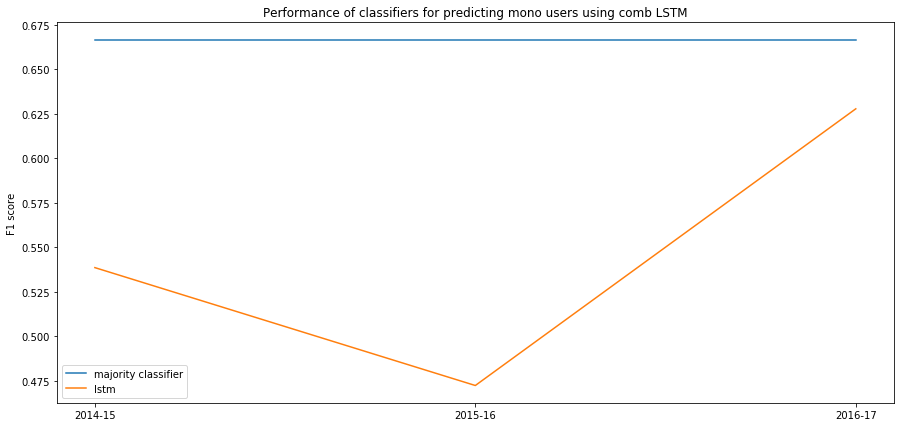

In [293]:
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]

lstm = [ele[0] for ele in lstm_scores]

## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using comb LSTM")
plt.ylabel("F1 score")
plt.legend()
plt.show()

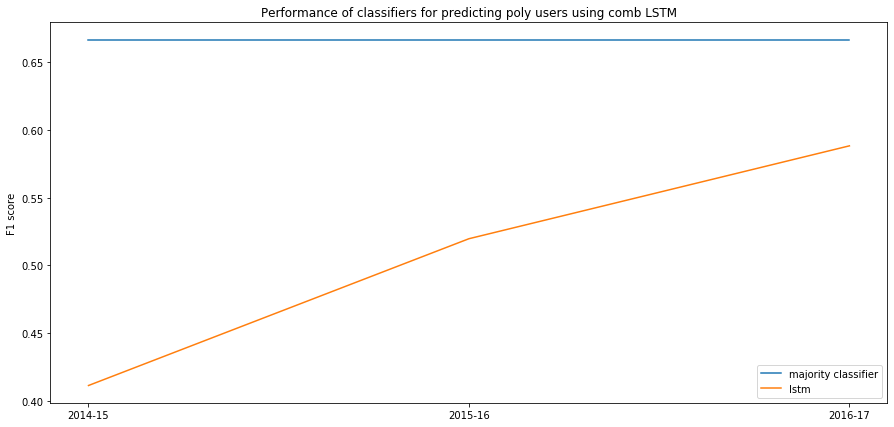

In [294]:
y_pred_maj = [1 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][1]

lstm = [ele[1] for ele in lstm_scores]

## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting poly users using comb LSTM")
plt.ylabel("F1 score")
plt.legend()
plt.show()